# Prediction of Cryptocurrency based on historical prices Step 3

We begin by importing the data collected from step 1 in order to use the cleaned data.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('./data/stepTwoData.csv', sep=',',header=0)
#df = pd.read_csv('./stepTwoData.csv', sep=',',header=0)
df.head()

,Unnamed: 0,Date,Open,High,Low,Close,Volume,Market Cap,Mean,normalize,Diff,Class
0,0,"Nov 07, 2017",7023.1000,7253.3200,7023.1000,7144.3800,2.326340e+09,1.170560e+11,7083.7400,5.624654,NaN,False
1,1,"Nov 06, 2017",7213.8100,7435.4000,7178.1450,7275.8950,2.353375e+09,1.202220e+11,7244.8525,5.769435,0.144781,False
2,2,"Nov 05, 2017",7404.5200,7617.4800,7333.1900,7407.4100,2.380410e+09,1.233880e+11,7405.9650,5.914215,0.144781,True
3,3,"Nov 04, 2017",7246.0250,7539.3850,7168.0650,7307.5850,2.875135e+09,1.207360e+11,7276.8050,5.798148,-0.116067,True
4,4,"Nov 03, 2017",7011.8975,7453.3575,6963.3925,7193.0425,3.764452e+09,1.168230e+11,7102.4700,5.641486,-0.156663,True


# Model Selection and Parameter Seaching

### 1. Grid Search and Cross Validation in a for loop

This checks several different models with several different parameters in order to find the best parameters 

The results can be seen below but from inital estimations it seems like Logistic Regression using a L1 penalty is the best model.

In [2]:
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression


y=df.iloc[:,-1].fillna(df.mean()).as_matrix()

x=df.iloc[:,2:8].fillna(df.mean()).as_matrix()

print y.shape
print x.shape

x = preprocessing.StandardScaler().fit_transform(x)  #normalizes data

models = [DecisionTreeClassifier(), 
          RandomForestClassifier(), 
          GradientBoostingClassifier(),
          SVC(),
          LogisticRegression()]
tuned_parameters = [{'criterion':["gini","entropy"], 'max_depth':[50, 3, 5, 10]},  # parameters for decision tree
                    {'n_estimators':[10,20], 'max_depth':[20, 3, 5, 10]}, # parameters for random forest
                    {'n_estimators':[100,50,10,150], 'max_depth':[2, 3, 5, 10]}, # parameters for gradient boosting
                    {'C': [1.0, 10.0], 'probability': [True, False]}, # parameters for SVC
                    {'penalty': ['l1', 'l2'], 'C': [1.0, 10.0, 25.0, 35.0, 100.0]}] # parameters for LogisticRegression

# Higher score means a better model
for model, tuned_parameter in zip(models, tuned_parameters):
    classify = GridSearchCV(model,tuned_parameter,cv=5,verbose=1)
    classify.fit(x,y)
    print classify.best_params_
    print classify.best_score_ 

(1412,)
(1412, 6)
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.4s finished


{'criterion': 'entropy', 'max_depth': 50}
0.492917847025
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    3.1s finished


{'n_estimators': 10, 'max_depth': 20}
0.440509915014
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   13.5s finished


{'n_estimators': 150, 'max_depth': 5}
0.479461756374
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    2.7s finished


{'C': 1.0, 'probability': True}
0.514872521246
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   12.9s finished


{'penalty': 'l1', 'C': 10.0}
0.798866855524


# Evaluation
### 1. Accuracy Score

This checks the accuracy score of the best parameters for each model.

It seems like logistic Regression does not have the best ROC and in fact the Decision Tree and Gradient Boosting seem to have the highest ROC.

In [3]:
from sklearn.metrics import r2_score, accuracy_score
models, percents = ['Decision Tree', 'Random Forest', 'Gradient Boosing', 'SVC', 'Logistic Regression'], []

classifies = [DecisionTreeClassifier(criterion='entropy', max_depth=50),
              RandomForestClassifier(n_estimators=10,max_depth=20),
              GradientBoostingClassifier(n_estimators=100, max_depth=5),
              SVC(C=1.0, probability=True),
              LogisticRegression(penalty='l1',C=10.0)
              ]

for classify in classifies:
    classify.fit(x,y)
    yhat=classify.predict(x)
    percents.append(accuracy_score(y,yhat))
    print accuracy_score(y,yhat)


1.0
0.984419263456
0.973796033994
0.544617563739
0.89447592068


# 2. ROC Area

This graph demonstrates the best ROC from our best model.  The ROC is about .89 which is fairly good.

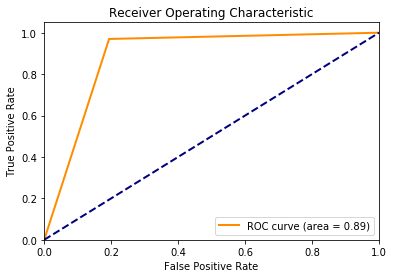

In [4]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y, yhat)
roc_auc = auc(fpr, tpr)
    
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
#plt.axis('equal')
#plt.axis([0, 0.5, 0, 1])
plt.show()

# Visualization: Matplotlib, bokeh, seaborn, plotly, d3.js:

# 1. Matplotlib

# Plot feature importance

This plot demonstrates how important each feature is when predicting the model.

['Open' 'High' 'Low' 'Close' 'Volume' 'Market Cap']
[ 0.47319165  0.02478013  0.1198502   0.3723327   0.00100918  0.00883614]


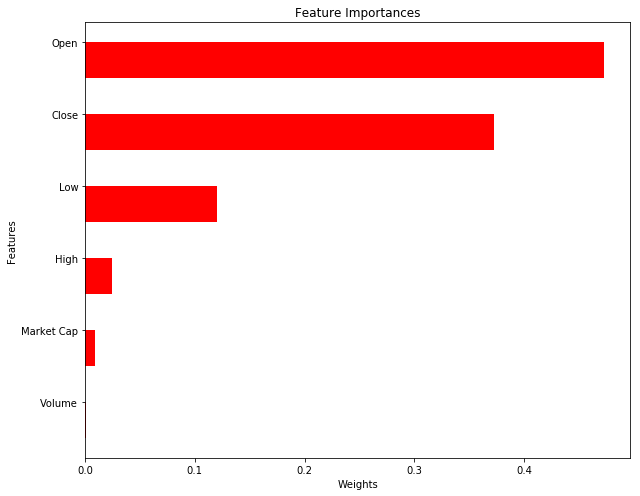

In [5]:
features= df.columns[2:8].values
print features
value = abs(classify.coef_[0])/sum(abs(classify.coef_[0]))
print value

ind=sorted(range(len(value)),reverse=False,key=lambda k: value[k])
features=features[ind]
value=sorted(value,reverse=False)
ind=np.array(range(6))
plt.rcParams['figure.figsize'] = (9,7)
plt.barh(bottom=ind,height=0.5,width=value,color='r')
plt.yticks(ind+0.25,features)
plt.xlabel('Weights')
plt.ylabel('Features')
plt.title('Feature Importances')
#plt.subplots_adjust(left=0.2)
plt.tight_layout()
#plt.savefig('feature_importances.png', format='png', dpi=300)
plt.show()

# Plot side-by-side comparison

This plot shows the open and close data on average over a period of 5 months.

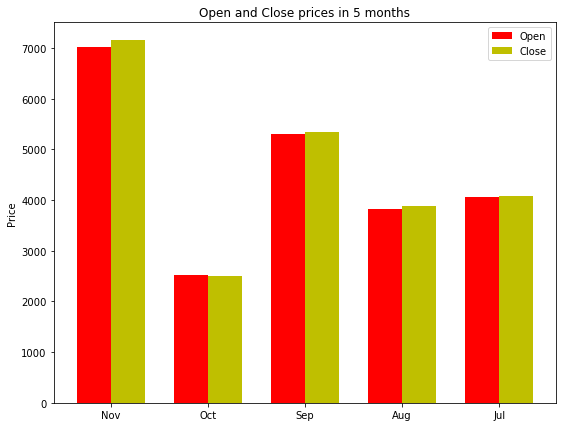

In [11]:
data = pd.read_csv('./data/armorastepTwoData2.csv', sep=',',header=0)
opendata = {'Nov':[], 'Oct':[], 'Sep':[], 'Aug':[], 'Jul':[]}
closedata = {'Nov':[], 'Oct':[], 'Sep':[], 'Aug':[], 'Jul':[]}

from scipy import mean
# print data
meandic = {}
for i in range(len(data)):
    if data['month'][i] == 'Nov':
        opendata['Nov'].append(data['Open'][i])
    if data['month'][i] == 'Oct':
        opendata['Oct'].append(data['Open'][i])
    if data['month'][i] == 'Sep':
        opendata['Sep'].append(data['Open'][i])
    if data['month'][i] == 'Aug':
        opendata['Aug'].append(data['Open'][i])
    if data['month'][i] == 'Jul':
        opendata['Jul'].append(data['Open'][i])

open_mean = list(map(lambda x: mean(opendata[x]), opendata))

for i in range(len(data)):
    if data['month'][i] == 'Nov':
        closedata['Nov'].append(data['Close'][i])
    if data['month'][i] == 'Oct':
        closedata['Oct'].append(data['Close'][i])
    if data['month'][i] == 'Sep':
        closedata['Sep'].append(data['Close'][i])
    if data['month'][i] == 'Aug':
        closedata['Aug'].append(data['Close'][i])
    if data['month'][i] == 'Jul':
        closedata['Jul'].append(data['Close'][i])
close_mean = list(map(lambda x: mean(closedata[x]), closedata))


ind = np.arange(len(opendata))  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, open_mean, width, color='r')

rects2 = ax.bar(ind + width, close_mean, width, color='y')

# add some text for labels, title and axes ticks
ax.set_ylabel('Price')
ax.set_title('Open and Close prices in 5 months')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('Nov', 'Oct', 'Sep', 'Aug', 'Jul'))

ax.legend((rects1[0], rects2[0]), ('Open', 'Close'))


plt.show()

# 2. seaborn

This graph shows the distribution of each feature in a kde plot

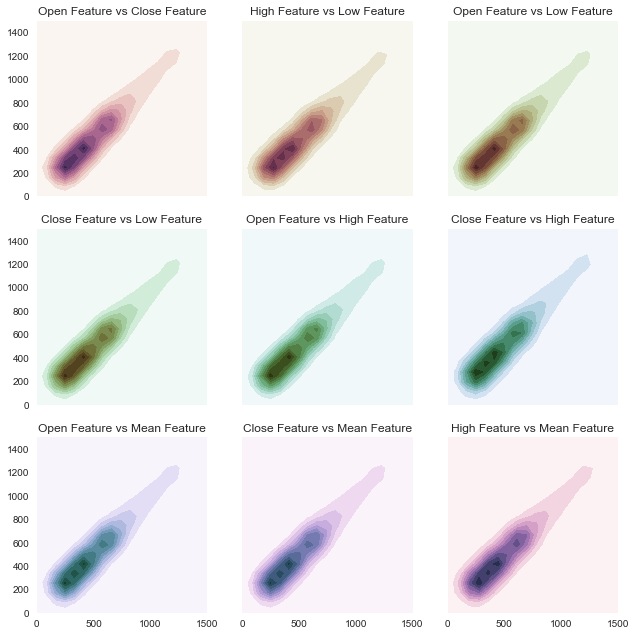

In [13]:
#Tali
#distribution of features in kde plot
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

#sns.set(color_codes=True)
#np.random.seed(sum(map(ord, "distributions")))

#sns.distplot(x);
#sns.distplot(x, kde=False, rug=True);


sns.set(style="dark")

# Set up the matplotlib figure
#f, axes = plt.subplots(3, 3, figsize=(9, 9), sharex=True, sharey=True)

openF = df.iloc[:,2].fillna(df.mean()).as_matrix()
highF = df.iloc[:,3].fillna(df.mean()).as_matrix()
lowF = df.iloc[:,4].fillna(df.mean()).as_matrix()
closeF = df.iloc[:,5].fillna(df.mean()).as_matrix()

#ax = sns.kdeplot(openF, closeF, cmap="Reds", shade=True, shade_lowest=False)
#ax = sns.kdeplot(highF, lowF, cmap="Blues", shade=True, shade_lowest=False)

#red = sns.color_palette("Reds")[-2]
#sns.jointplot(openF, closeF, kind="kde")

# Set up the matplotlib figure
f, axes = plt.subplots(3, 3, figsize=(9, 9), sharex=True, sharey=True)

count = 0
# Rotate the starting point around the cubehelix hue circle
for ax, s in zip(axes.flat, np.linspace(0, 3, 10)):
    count += 1
    # Create a cubehelix colormap to use with kdeplot
    cmap = sns.cubehelix_palette(start=s, light=1, as_cmap=True)

    if count == 1:
        #Open and close
        x = df.iloc[:,2].fillna(df.mean()).as_matrix()
        y = df.iloc[:,5].fillna(df.mean()).as_matrix()
    if count == 2:
        #high and low
        x = df.iloc[:,3].fillna(df.mean()).as_matrix()
        y = df.iloc[:,4].fillna(df.mean()).as_matrix()
    if count == 3:
        #open and low
        x = df.iloc[:,2].fillna(df.mean()).as_matrix()
        y = df.iloc[:,4].fillna(df.mean()).as_matrix()
    if count == 4:
        #close and low
        x = df.iloc[:,5].fillna(df.mean()).as_matrix()
        y = df.iloc[:,4].fillna(df.mean()).as_matrix()
    if count == 5:
        #open and high
        x = df.iloc[:,2].fillna(df.mean()).as_matrix()
        y = df.iloc[:,4].fillna(df.mean()).as_matrix()
    if count == 6:
        #close and high
        x = df.iloc[:,5].fillna(df.mean()).as_matrix()
        y = df.iloc[:,3].fillna(df.mean()).as_matrix()
    if count == 7:
        #Open and mean
        x = df.iloc[:,2].fillna(df.mean()).as_matrix()
        y = df.iloc[:,8].fillna(df.mean()).as_matrix()
    if count == 8:
        #close and mean
        x = df.iloc[:,5].fillna(df.mean()).as_matrix()
        y = df.iloc[:,8].fillna(df.mean()).as_matrix()
    if count == 9:
        #high and mean
        x = df.iloc[:,3].fillna(df.mean()).as_matrix()
        y = df.iloc[:,8].fillna(df.mean()).as_matrix()
    axes[0, 0].set_title('Open Feature vs Close Feature')
    axes[0, 1].set_title('High Feature vs Low Feature')
    axes[0, 2].set_title('Open Feature vs Low Feature')
    axes[1, 0].set_title('Close Feature vs Low Feature')
    axes[1, 1].set_title('Open Feature vs High Feature')
    axes[1, 2].set_title('Close Feature vs High Feature')
    axes[2, 0].set_title('Open Feature vs Mean Feature')
    axes[2, 1].set_title('Close Feature vs Mean Feature')
    axes[2, 2].set_title('High Feature vs Mean Feature')
    sns.kdeplot(x, y, cmap=cmap, shade=True, cut=5, ax=ax)
    ax.set(xlim=(0, 1500), ylim=(0, 1500))

f.tight_layout()
plt.show()

# 3. bokeh

This graph demonstrates the accuracy of each of our models.

In [6]:
#Matt
from bokeh.io import show, output_file
from bokeh.models import ColumnDataSource
from bokeh.palettes import Spectral6
from bokeh.plotting import figure


output_file("bar_colormapped.html")

source = ColumnDataSource(data=dict(models=models, percents=percents))

p = figure(x_range=models, plot_height=350, toolbar_location=None, title="Percentage of Accuracy")
p.vbar(x='models', top='percents', width=0.9, source=source,
       line_color='white')

p.xgrid.grid_line_color = None
p.y_range.start = 0
p.y_range.end = 1.1
p.legend.orientation = "horizontal"
p.legend.location = "top_center"

show(p)

# 4. Plotly

This graph interactivly shows the change in price over time. Plotly is the best way to display this due to the many close data points

In [5]:
#Armora
#price vs time for different features

init_notebook_mode(connected=True)
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

df = pd.read_csv('./stepTwoData.csv')

data = [go.Scatter(x=df.Date[::-1], y=df.Mean[::-1],mode = 'line+markers', name = 'lines+markers')]

iplot(data, filename='line-mode')

## Test Data
This generates randomized testing data and then predicts it with the same models.

In [14]:
import random
import pandas as pd
import numpy as np
df = pd.read_csv('./data/stepTwoData.csv', sep=',',header=0)
df.head()

,Unnamed: 0,Date,Open,High,Low,Close,Volume,Market Cap,Mean,normalize,Diff,Class
0,0,"Nov 07, 2017",7023.1000,7253.3200,7023.1000,7144.3800,2.326340e+09,1.170560e+11,7083.7400,5.624654,NaN,False
1,1,"Nov 06, 2017",7213.8100,7435.4000,7178.1450,7275.8950,2.353375e+09,1.202220e+11,7244.8525,5.769435,0.144781,False
2,2,"Nov 05, 2017",7404.5200,7617.4800,7333.1900,7407.4100,2.380410e+09,1.233880e+11,7405.9650,5.914215,0.144781,True
3,3,"Nov 04, 2017",7246.0250,7539.3850,7168.0650,7307.5850,2.875135e+09,1.207360e+11,7276.8050,5.798148,-0.116067,True
4,4,"Nov 03, 2017",7011.8975,7453.3575,6963.3925,7193.0425,3.764452e+09,1.168230e+11,7102.4700,5.641486,-0.156663,True


In [15]:
df = df[:301]
for x in range(301):
    for y in range(2,8):
        df.iloc[x,y] += random.uniform(-10, 10)


df['Class'] = None #Creates a class analysis for the data
for y in range(len(df)-1):
    if df.loc[y+1,'Close'] < df.loc[y,'Close']:
        df.loc[y, 'Class'] = True
    else:
        df.loc[y, 'Class'] = False
        
df = df.drop(df.index[-1])
df.head()

y=df.iloc[:,-1].fillna(df.mean()).as_matrix()

x=df.iloc[:,2:8].fillna(df.mean()).as_matrix()


models, percents = ['Decision Tree', 'Random Forest', 'Gradient Boosing', 'SVC', 'Logistic Regression'], []

classifies = [DecisionTreeClassifier(criterion='entropy', max_depth=50),
              RandomForestClassifier(n_estimators=10,max_depth=20),
              GradientBoostingClassifier(n_estimators=100, max_depth=5),
              SVC(C=1.0, probability=True),
              LogisticRegression(penalty='l1',C=10.0)
              ]

for classify in classifies:
    classify.fit(x,y)
    yhat=classify.predict(x)
    percents.append(accuracy_score(y,yhat))
    print accuracy_score(y,yhat)

1.0
0.983333333333
1.0
1.0
0.846666666667


#### Secondary Test
We input this data Tuesday to predict whether the price will rise and fall wednesday.

In [16]:
x = np.array([11616.85, 11860.25, 11473.51, 11755.20, 16722375, 197000000])
x.reshape(-1, 1)
print classify.predict(x)

[ True]


/anaconda/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
